# DNN - Tutorial 2 Part I: Physics inspired Machine Learning

**Sparse Identification of Nonlinear Dynamical Systems (SINDy)**

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Dynamical_Neural_Networks/Complete_DNN_2_1.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1floNK3pbRWYkMYH3_pN-GKJ8pOMEDZV6/view?usp=sharing)   
**Authors:**
Leonard Bereska and Ilze Amanda Auzina

This section provides an overview of the Sparse Identification of Nonlinear Dynamical systems (SINDy) algorithm, which was first proposed in:

> Brunton, Steven L., Joshua L. Proctor, and J. Nathan Kutz. 2016. *“Discovering Governing Equations from Data by Sparse Identification of Nonlinear Dynamical Systems.”* Proceedings of the National Academy of Sciences 113 (15): 3932–37. https://doi.org/10.1073/pnas.1517384113. 

## What do we mean by *identifying* nonlinear dynamics from data?

Suppose we have time-series data that originate from a (nonlinear) dynamical system.  
- To identify a system means to infer the governing equations of that system based on the data. 
- That is, to find $f$ for dynamical systems equations $\mathbf{\dot x} = f(\mathbf{x})$ (where $\mathbf{x}$ may be vector-valued).

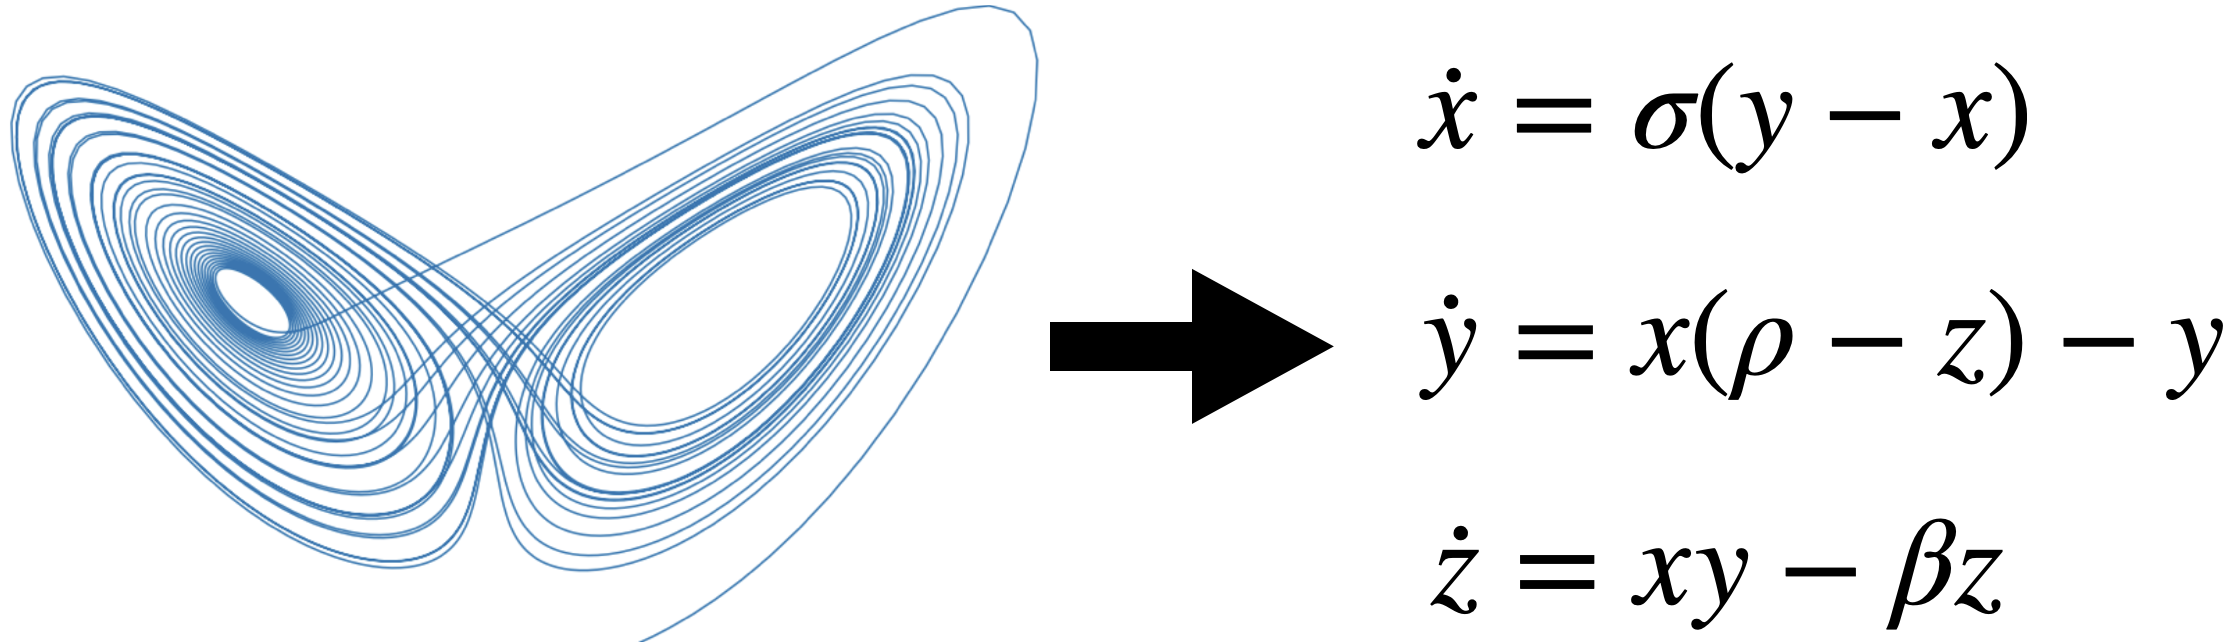
For example for the Lorenz system, we want to learn the **equations** on the *right* from the time-series **data** visualized on the *left*.

## Why do we want *sparsity*?

In this context, by sparse we mean a low number of terms in the governing equations. Sparsity is beneficial, because it is more:
1. **Interpretible**. Crucial, when understanding the variables and their interactions is needed, e.g. for applications with safety-critical guarantees.
2. **Generalizable**. If correct, the equations describe the dynamics accurately beyond the region of state space filled by the training data.

In general, one can think of the models identified by SINDy as equations from physics as opposed to big, opaque, deep neural networks.

## SINDy Algorithm

SINDy tries to find the dynamical system $f$ that suits the data $\mathrm{\dot X} = f(\mathrm{X})$. This function approximation problem is formulated as linear regression $\mathrm{\dot X} = \Theta(\mathrm{X})  \Xi$, with coefficients $\Xi$ and a library of regression terms $\Theta(X)$. The algorithm proceeds in three steps:

1. Generate data $X$ from a dynamical system and compute derivatives $\dot X$.
2. Set up library of candidate terms $\Theta(X)$ as functions on $X$.
3. Sparsely regress the coefficients $\Xi$, that best describe the data.

1. SINDy assumes a time-series of $n$-dimensional data points $\mathbf{x}=(x_1, \ldots x_n)$ measured at $m$ time steps $t_1, \ldots,  t_m$, we define the data matrix $X$ as and derivatives matrix $\dot X$: 

$$X = \begin{bmatrix}
x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
\end{bmatrix},
\qquad
\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
\vdots & \vdots & & \vdots \\
\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
\end{bmatrix}.$$

2. Next, we define the library matrix $\Theta(X)$, the columns of which are a set of basis functions $\{\theta_l\}_{l=1,\ldots, L}$ applied to the data:

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}.
$$

Simple examples are e.g. a basis of polynomials $x_1, x_2, x_1^2, x_2^2, x_1 x_2, x_1^3 \ldots$, such as in the *Taylor expansion*, or trigonometric functions $\sin(x_1), \cos (x_1), \sin(2 x_1), \ldots $, such as in a *Fourier expansion*. But, depending on the problem more complex basis may be appropriate, e.g. Bessel functions.

3. Lastly, we employ a sparse linear regression algorithm (such as e.g. LASSO) to find the coefficients $\Xi$,
$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}, 
$$

such that 

$$\mathrm{\dot X} = \Theta(\mathrm{X})  \Xi.$$

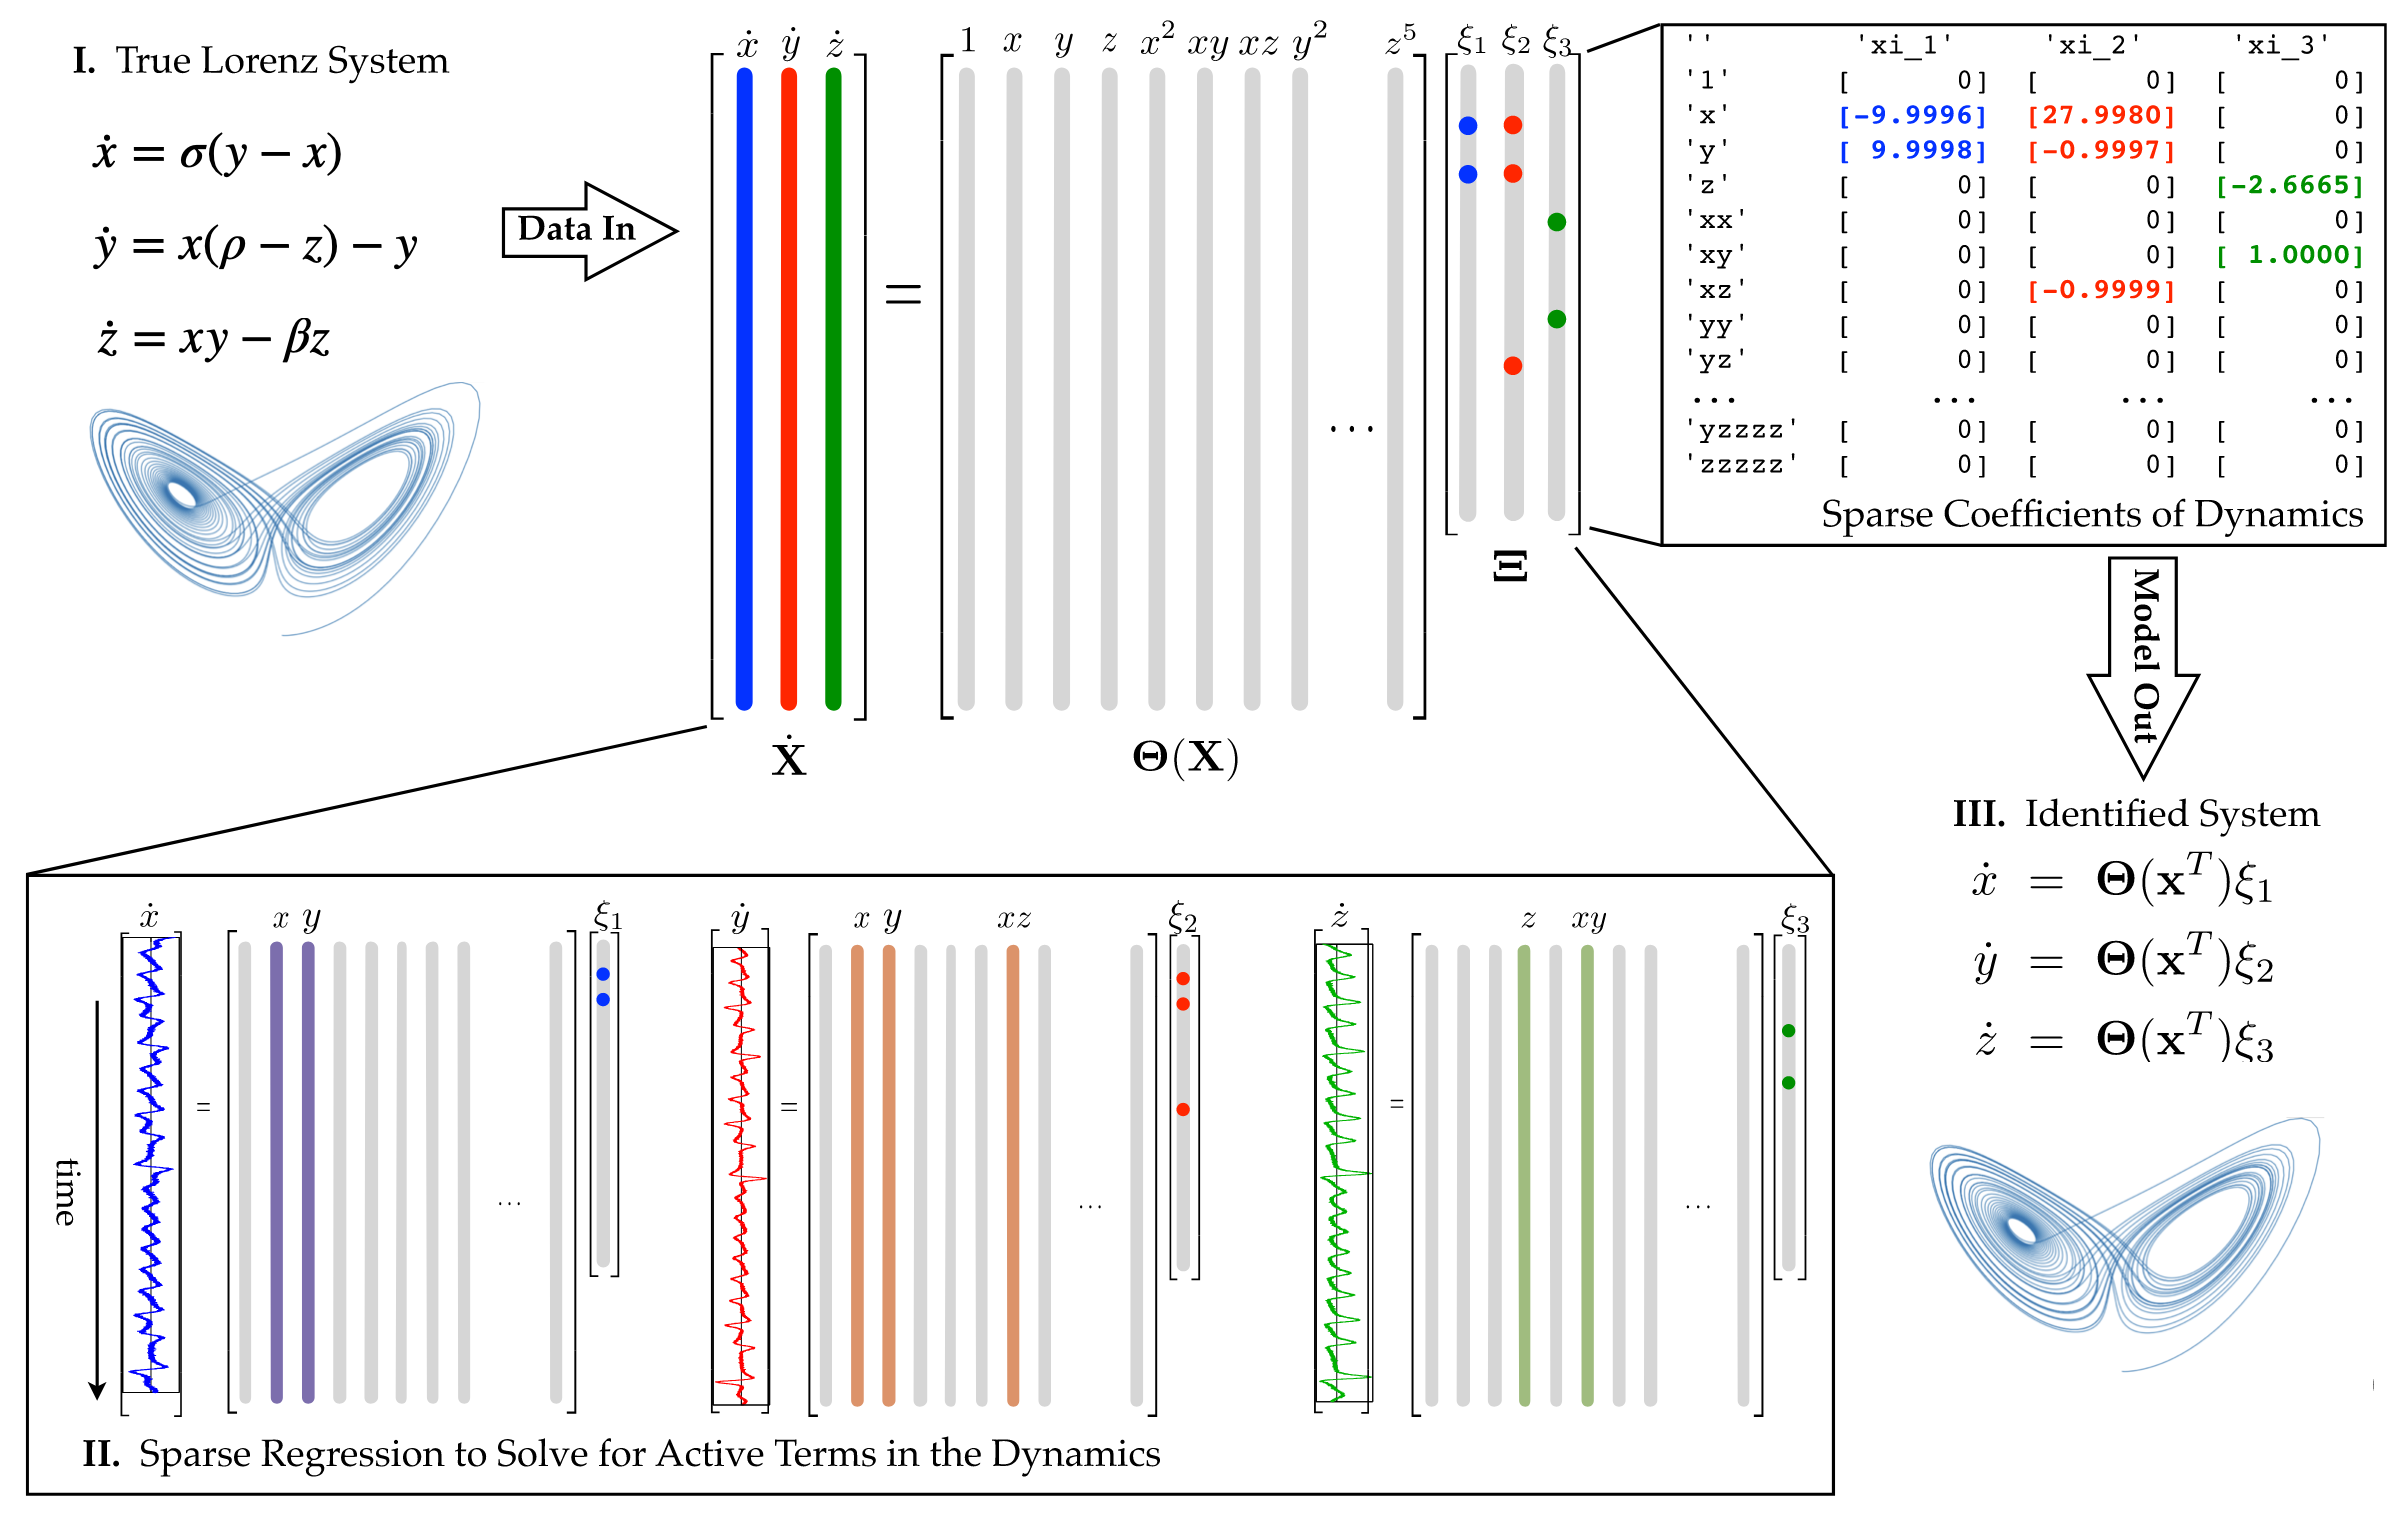

## Example: Linear Dynamical System

Suppose we measure a particle trajectory that is governed by the following dynamical system:

$$
	\frac{d}{dt} \begin{pmatrix} x \\ y \end{pmatrix}
	= \begin{pmatrix} -2x \\ y \end{pmatrix}
	= \begin{pmatrix} -2 & 0 \\ 0 & 1 \end{pmatrix}
	\begin{pmatrix} x \\ y \end{pmatrix}
$$

With the initial conditions $x_0 = 3$ and $y_0 = \tfrac{1}{2}$, we construct the data matrix $X$:

In [4]:
import numpy as np
import pysindy as ps

t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1) 

When instantiating a SINDy model, we can choose the differentiation method, the library and the optimizer:

Let's first investigate a Fourier basis as a basis function

In [18]:
model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.FourierLibrary(),
    optimizer=ps.STLSQ(threshold=0.2),
    feature_names=["x", "y"]
)
model.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.fourier_library.FourierLibrary object at 0x137889100>,
      feature_names=['x', 'y'], optimizer=STLSQ(threshold=0.2))

After fitting the model can be inspected with the *print* member function.

In [19]:
model.print()

(x)' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
(y)' = 1.362 sin(1 y) + -0.222 cos(1 y)


Let us verify this on some test data:

In [20]:
import matplotlib.pyplot as plt
def plot_simulation(model, x0, y0):
    t_test = np.linspace(0, 1, 100)
    x_test = x0 * np.exp(-2 * t_test)
    y_test = y0 * np.exp(t_test)
    
    sim = model.simulate([x0, y0], t=t_test)

    plt.figure(figsize=(6, 4))
    plt.plot(x_test, y_test, label="Ground truth", linewidth=4)
    plt.plot(sim[:, 0], sim[:, 1], "--", label="SINDy estimate", linewidth=3)
    plt.plot(x0, y0, "ko", label="Initial condition", markersize=8)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

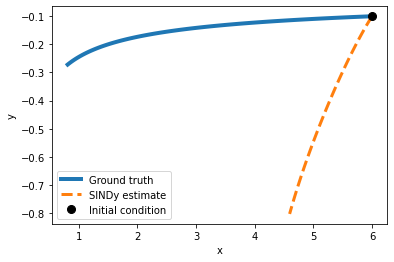

In [21]:
x0 = 6
y0 = -0.1
plot_simulation(model, x0,y0)

As we may have expected, a Fourier basis is not optimal for this problem. Let's try a differetn basis function! 

**Exercise 1** Let's investigate what happens if we choose a different basis function. 

Implement a Sindy algorithm class with a Fourier basis by initializing `ps.SINDy()` with the `feature_library` attribute set to `ps.PolynomialLibrary()`. Fit the instantiated algorithm with the `.fit(X, t=t)` method. 

In [103]:
model_1 = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=1),
    optimizer=ps.STLSQ(threshold=0.2),
    feature_names=["x", "y"]
)
model_1.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=1), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [104]:
model_1.print()

(x)' = -2.000 x
(y)' = 1.000 y


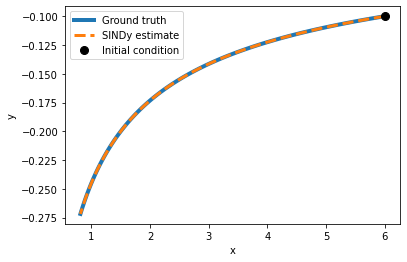

In [105]:
x0 = 6
y0 = -0.1
plot_simulation(model_1, x0,y0)

As we can see in this (simple) case, the model has perfectly identified the underlying equation by using polynomial basis functions.

Our problem was a first-order polynomial differential equation, so it is only natural that regression with exactly these model assumptions succeeds.

 **Exercise 1.1** At which degree is SINDy not able anymore to correctly identify the equation? At which degree do the predictions on a test set diverge? Test this by successively increasing the `degree` of the polynomial.

In [106]:
model_1 = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=4),
    optimizer=ps.STLSQ(threshold=0.2),
    feature_names=["x", "y"]
)
model_1.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [107]:
model_1.print()

(x)' = -1.280 x + -0.960 x^2 y^2
(y)' = 1.000 y


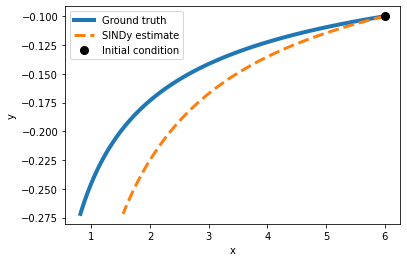

In [108]:
x0 = 6
y0 = -0.1
plot_simulation(model_1, x0,y0)

**Exercise 1.2** What happens if you set the threshold too low? What if it is too high?

[STLSQ](https://deeptime-ml.github.io/trunk/api/generated/deeptime.sindy.STLSQ.html) : Attempts to minimize the objective function $||y-Xw||_{2}^{2}+\alpha ||w||_{2}^{2}$​ by iteratively performing least squares and masking out elements of the weight that are below a given threshold.

**threshold** : minimum magnitude for a coefficient in the weight vector. Coefficients with magnitude below the threshold are set to zero.

In [109]:
model_1 = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=4),
    optimizer=ps.STLSQ(threshold=0.1),
    feature_names=["x", "y"]
)
model_1.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4), feature_names=['x', 'y'],
      optimizer=STLSQ())

In [110]:
model_1.print()

(x)' = -1.277 x + 0.001 x^2 + -0.002 x y + -0.005 x^2 y + -0.958 x^2 y^2
(y)' = 3063674878.195 y + -4084899836.260 x y^3


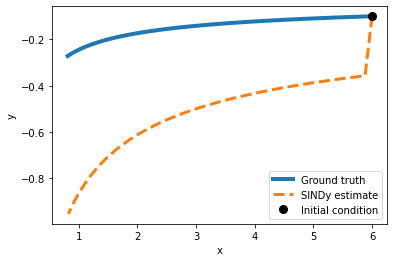

In [111]:
x0 = 6
y0 = -0.1
plot_simulation(model_1, x0,y0)

## Example: Lorenz attractor

For testing SINDy on the Lorenz attractor we first simulate a trajectory from the ground truth equations: 

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state  
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1.0, 1.0, 1.0]
time_steps = np.arange(0.0, 40.0, dt)

x_train = odeint(f, state0, time_steps)

In [113]:
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=2),
)

model.fit(x_train, t=dt)

x_sim = model.simulate(x_train[0], time_steps)

In [114]:
model.print()

(x0)' = -9.977 x0 + 9.977 x1
(x1)' = 27.806 x0 + -0.962 x1 + -0.995 x0 x2
(x2)' = -2.659 x2 + 0.997 x0 x1


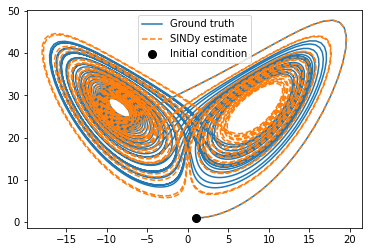

In [115]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:, 0], x_train[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

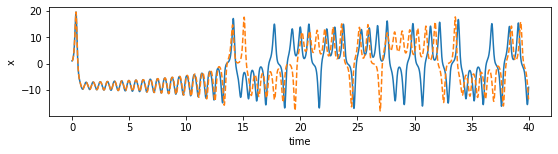

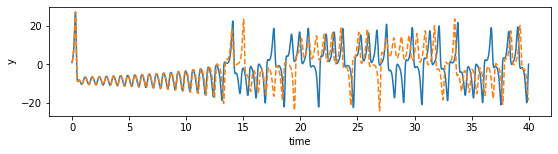

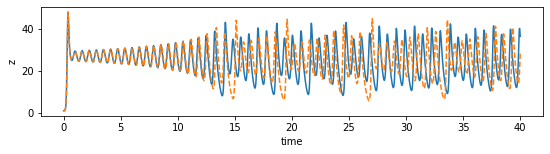

In [116]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(time_steps, x_train[:, dim])
    ax.plot(time_steps, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)

plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

We can see that the prediction tracks the ground truth data very faithfully, until it diverges (which is inevitable by the chaotic nature of the system).

## Challenges

The previous examples have been very basic with a lot of implicit assumptions. Applying SINDy to real-world data is more challenging on multiple fronts. The challenges arise from:
1. **Data**. How much and what quality of data is needed?
    Per default, SINDy relies on clean data, rapidly sampled in time, with little noise. Needs to be clean enough to compute derivatives. But these requirements can be traded off against each other: e.g., if the data is clean, little is fine. Conversely, for ample but noisy data, one can average out the noise by integration.
2. **Coordinates**. Which variables to measure? Use expert domain knowledge if possible. Alternatively, apply singular value decomposition to find most relevant variables. Or train a deep autoencoder in combination with SINDy: 
>Champion, Kathleen, Bethany Lusch, J. Nathan Kutz, and Steven L. Brunton. 2019. “Data-Driven Discovery of Coordinates and Governing Equations.” Proceedings of the National Academy of Sciences of the United States of America 116 (45): 22445–51. https://doi.org/10.1073/pnas.1906995116.

3. **Library**. What library terms capture the dynamics best? Practically, start simple, e.g. with linear terms, then quadratic etc.. One may also use domain knowledge. Be careful, to not expand the library too big, to avoid linear dependence of columns resulting in an ill-conditioned matrix $\Theta(X)$. Prior knowledge on physics can yield symmetry constraints that cross out symmetry-incompatible terms in library. 
4. **Optimization**. Which algorithm to use? How do I actually find sparse terms? Simplest is LASSO, in practice Sequential Threshold Least Squares (iteratively hard-thresholding coefficients) works better. Here, one may also incorporate *physics-informed* constraints: for example one can enforce energy conservation or global stability directly in the optimization.

In the past years, a lot has been achieved in this regard and SINDy has been successful in a variety of real-world applications, including discovering equations for plasma fluid dynamics that previously had not been analytically formulated due to the complexity of the problem.

### Sources
- https://pysindy.readthedocs.io/en/latest/#how-it-works
- https://pysindy.readthedocs.io/en/latest/examples/2_introduction_to_sindy.html
- Part 1: https://www.youtube.com/watch?v=NxAn0oglMVw
- Part 2: https://www.youtube.com/watch?v=8-hoWTJwmrE
- Part 3: https://www.youtube.com/watch?v=1vrsBg92Xzo
- Part 4: https://www.youtube.com/watch?v=MmMNQe_EtCw
- Part 5: https://www.youtube.com/watch?v=pY2iJnngk4g

## Reservoir Computing

Reservoir computing is a simple method for training recurrent neural networks without backpropagation through time and the associated notorious vanishing and exploding gradient problems. The basic steps are:

1. Randomly initialize recurrent neural network weights.
2. Fix hidden connection weights.
3. Train linear output layer with linear regression.

More formally, the state of the recurrent neural network of $M$ neurons is given by its hidden activations $\mathbf{h} \in \mathbb{R}^{M}$, which are connected by randomly initialized and fixed matrix $\mathbf{W}_{\mathrm{h}}$.
An input sequence $\mathbf{X}_{1:\tau}$ is embedded by a linear map $\mathbf{W}_{\mathrm{i}}$ to the state $\mathbf{h}_\tau$:

$$
    \begin{split}
        \mathbf{h}_1 &= \sigma (\mathbf{W}_{\mathrm{h}} \mathbf{h}_0 +\mathbf{W}_{\mathrm{i}}\mathbf{x}_1) \\
    \vdots &\phantom{a}\hspace{1cm} \vdots\\
    \mathbf{h}_\tau &= \sigma (\mathbf{W}_{\mathrm{h}} \mathbf{h}_{\tau -1} + \mathbf{W}_{\mathrm{i}} \mathbf{x}_\tau).
    \end{split}
$$

Then, the reservoir can linearly predict the next input $\mathbf{x}_{\tau +1}$, based on the hidden state $\mathbf{h}_\tau$:

\begin{equation}
    \mathbf{\hat {x}}_{\tau +1} = \mathbf{W}_{\mathrm{o}} \mathbf{h}_\tau,
\end{equation}

with $\mathbf{W}_{\mathrm{o}}$ mapping from hidden activation to output.
Only the parameters of this output matrix $\mathbf{W}_{\mathrm{o}}$ are trained. Hence, the optimal values can be obtained analytically via ridge regression (with regularization parameter $\lambda$) as:

$$
    \mathbf{W}_{\mathrm{o}} = (\mathbf{H}^T\mathbf{H} + \lambda \mathbf{I})^{-1} \mathbf{H}^T \mathbf{X},
$$

where $\mathbf{H}$ are the hidden states, $\mathbf{I}$ the identity matrix, and $\mathbf{X}$ the targets of the regression.

## Example: Lorenz Attractor

In [117]:
from scipy import sparse

radius = 0.6
sparsity = 0.01
input_dim = 3
reservoir_size = 1000
n_steps_prerun = 10
regularization = 1e-2
sequence = x_train

Randomly initialize the network weights:

In [118]:
weights_hidden = sparse.random(reservoir_size, reservoir_size, density=sparsity)
eigenvalues, _ = sparse.linalg.eigs(weights_hidden)
weights_hidden = weights_hidden / np.max(np.abs(eigenvalues)) * radius

weights_input = np.zeros((reservoir_size, input_dim))
q = int(reservoir_size / input_dim)
for i in range(0, input_dim):
    weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1
    
weights_output = np.zeros((input_dim, reservoir_size))

Embed the sequence into the hidden state of the network:

In [119]:
def initialize_hidden(reservoir_size, n_steps_prerun, sequence):
    hidden = np.zeros((reservoir_size, 1))
    for t in range(n_steps_prerun):
        input = sequence[t].reshape(-1, 1)
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    return hidden

def augment_hidden(hidden):
    h_aug = hidden.copy()
    h_aug[::2] = pow(h_aug[::2], 2.0)
    return h_aug

hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
hidden_states = []
targets = []

for t in range(n_steps_prerun, len(sequence) - 1):
    input = np.reshape(sequence[t], (-1, 1))
    target = np.reshape(sequence[t + 1], (-1, 1))
    hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    hidden = augment_hidden(hidden)
    hidden_states.append(hidden)
    targets.append(target)
    
targets = np.squeeze(np.array(targets))
hidden_states = np.squeeze(np.array(hidden_states))

Ridge regression to obtain the linear output layer weights:

In [120]:
weights_output = (np.linalg.inv(hidden_states.T@hidden_states + regularization * np.eye(reservoir_size)) @ hidden_states.T@targets).T

In [121]:
def predict(sequence, n_steps_predict):
    hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
    input = sequence[n_steps_prerun].reshape((-1, 1))
    outputs = []

    for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
        hidden = augment_hidden(hidden)
        output = weights_output @ hidden
        input = output
        outputs.append(output)
    return np.array(outputs)

In [122]:
x_sim = predict(sequence, 4000)

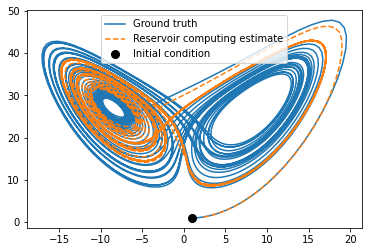

In [123]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:4000, 0], x_train[:4000, 2], label="Ground truth")
plt.plot(x_sim[:, 0], x_sim[:, 2],'--', label="Reservoir computing estimate")
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)

plt.legend()
plt.show()

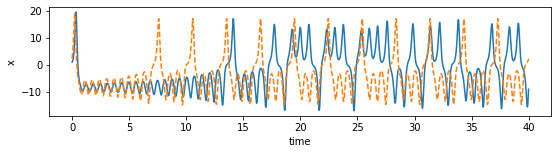

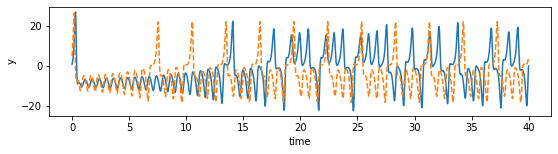

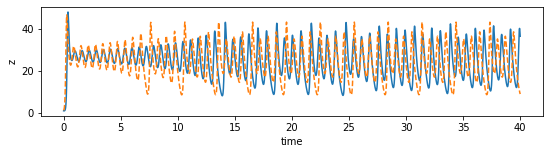

In [124]:
plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

A successful application of reservoir computing to data-driven estimation of nonlinear dynamical systems is for example:

>Jaideep Pathak et al., “Model-Free Prediction of Large Spatiotemporally Chaotic Systems from Data: A Reservoir Computing Approach,” Physical Review Letters 120, no. 2 (January 12, 2018): 024102, https://doi.org/10.1103/PhysRevLett.120.024102.